In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.signal import butter, filtfilt, resample_poly, medfilt


In [2]:
# --- Step 1: Load CSV file ---
df = pd.read_csv('combined_patient_ecg_outcome.csv')

# --- Step 2: Parsing function for space-separated ECG string to 1D numpy array ---

def string_to_float_array_fixed(s):
    values = []
    for val in s.strip().split():
        try:
            values.append(float(val))
        except:
            values.append(np.nan)
    return np.array(values)

df['data_array'] = df['data'].apply(string_to_float_array_fixed)

# --- Step 3: NaN interpolation helper ---

def interpolate_nan(data):
    n = len(data)
    if n == 0:
        return data

    indices = np.arange(n)
    valid = ~np.isnan(data)

    if valid.sum() == 0:
        return np.zeros_like(data)

    return np.interp(indices, indices[valid], data[valid])

# --- Step 4: Save raw numpy arrays with NaNs interpolated ---

np_folder = 'ecg_numpy_arrays'
os.makedirs(np_folder, exist_ok=True)

for _, row in df.iterrows():
    patient_id = row['patient_id']
    ecg_array = row['data_array']
    ecg_array_clean = interpolate_nan(ecg_array)
    np.save(os.path.join(np_folder, f"{patient_id}_ecg.npy"), ecg_array_clean)

print(f"Saved {len(df)} raw ECG numpy files with NaNs interpolated.")

Saved 99 raw ECG numpy files with NaNs interpolated.


In [3]:
df.head()


,patient_id,data,label,data_array
0,284,24433.0 24317.0 24354.0 24377.0 24270.0 24272....,1,"[24433.0, 24317.0, 24354.0, 24377.0, 24270.0, ..."
1,286,-31920.0 -31920.0 -31920.0 -31920.0 -31920.0 -...,1,"[-31920.0, -31920.0, -31920.0, -31920.0, -3192..."
2,296,3221.0 3274.0 3380.0 3098.0 2843.0 2910.0 3274...,1,"[3221.0, 3274.0, 3380.0, 3098.0, 2843.0, 2910...."
3,299,18584.0 18488.0 18648.0 19008.0 19239.0 19347....,1,"[18584.0, 18488.0, 18648.0, 19008.0, 19239.0, ..."
4,303,26985.0 10038.0 -9400.0 -20411.0 -18704.0 -419...,1,"[26985.0, 10038.0, -9400.0, -20411.0, -18704.0..."


In [4]:
# Filter, Resample, Median Filter

original_fs = 310.0
target_fs = 100.0  # Increased to preserve more signal details
cutoff_frequency = 30.0  # Adjusted for ECG feature retention
filter_order = 3
median_kernel_size = 3  # Reduced to avoid over-smoothing

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, data)

def resample_ecg(data, original_fs, target_fs):
    from math import gcd
    g = gcd(int(original_fs), int(target_fs))
    up = int(target_fs // g)
    down = int(original_fs // g)
    return resample_poly(data, up, down)

# Save filtered ECG arrays
filtered_folder = 'ecg_processed_arrays'
os.makedirs(filtered_folder, exist_ok=True)

for _, row in df.iterrows():
    pid = row['patient_id']
    ecg = np.load(os.path.join(np_folder, f"{pid}_ecg.npy"))
    ecg_resampled = resample_ecg(ecg, original_fs, target_fs)
    ecg_median = medfilt(ecg_resampled, kernel_size=median_kernel_size)
    ecg_filtered = butter_lowpass_filter(ecg_median, cutoff_frequency, target_fs, filter_order)
    np.save(os.path.join(filtered_folder, f"{pid}_processed.npy"), ecg_filtered)

print(f"Saved filtered ECG arrays for {len(df)} patients.")

Saved filtered ECG arrays for 99 patients.


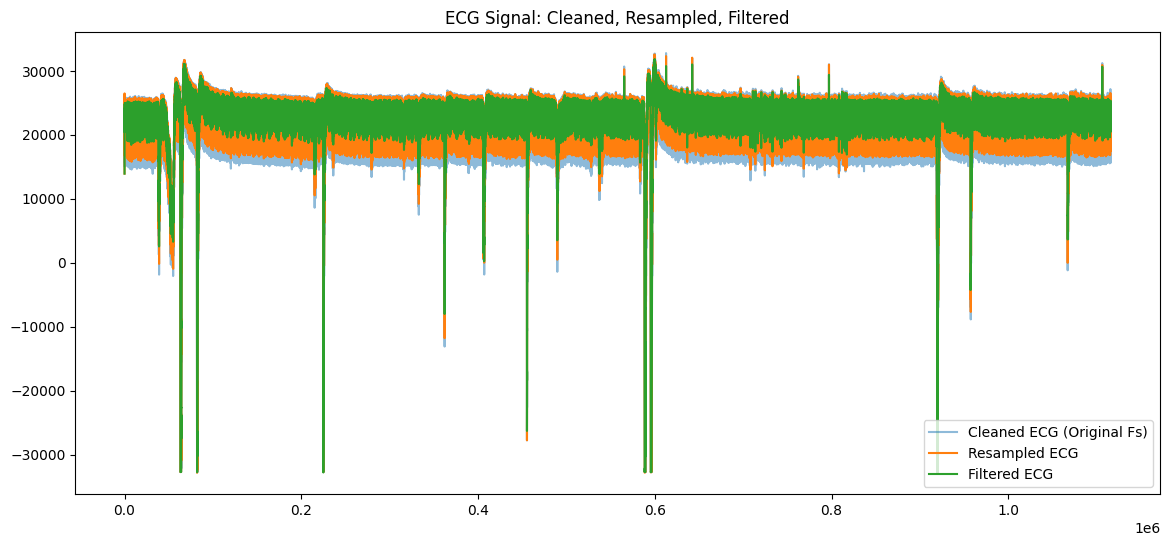

In [ ]:
# plt.figure(figsize=(14,6))
# plt.plot(ecg_clean, alpha=0.5, label='Cleaned ECG (Original Fs)')
# plt.plot(np.linspace(0,len(ecg_clean),len(ecg_resampled)), ecg_resampled, label='Resampled ECG')
# plt.plot(np.linspace(0,len(ecg_clean),len(ecg_filtered)), ecg_filtered, label='Filtered ECG')
# plt.legend()
# plt.title("ECG Signal: Cleaned, Resampled, Filtered")
# plt.show()

In [5]:
# Save Filtered ECG Files & Segment into Windows
# Save filtered ECG numpy arrays for all patients (optional)
class RawECGSegmentDataset(Dataset):
    def __init__(self, np_folder, labels_dict, fs=100, window_sec=10, overlap_sec=5):
        self.fs = fs
        self.window_len = int(window_sec * fs)
        self.overlap_len = int(overlap_sec * fs)
        self.samples = []
        self.labels = []

        files = [f for f in os.listdir(np_folder) if f.endswith('.npy')]
        for file in files:
            pid = int(file.split('_')[0])
            label = labels_dict.get(pid)
            if label is None:
                continue
            data = np.load(os.path.join(np_folder, file))
            n = len(data)
            start = 0
            while start + self.window_len <= n:
                window = data[start:start + self.window_len]
                self.samples.append(window.astype(np.float32))
                self.labels.append(label)
                start += (self.window_len - self.overlap_len)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

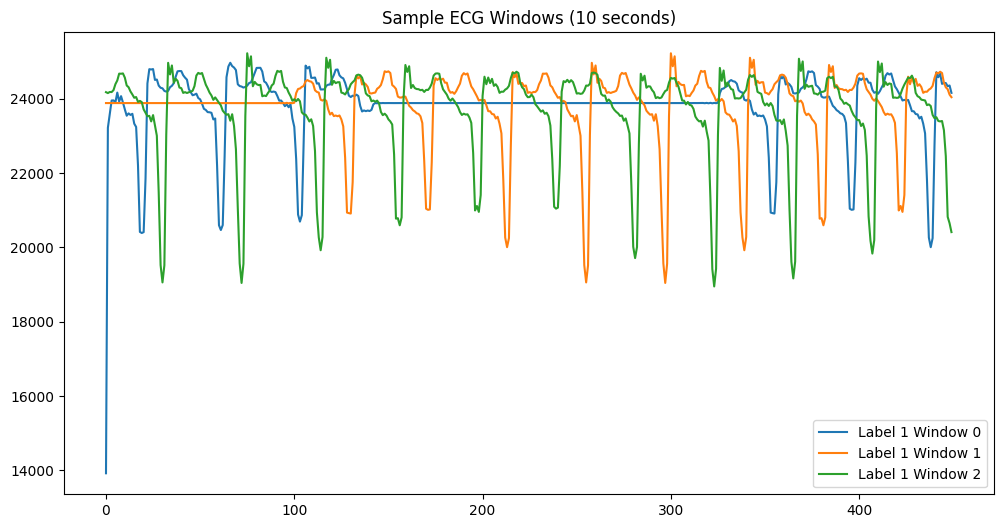

In [ ]:
# # Plot a few sample windows
# plt.figure(figsize=(12,6))
# for i in range(3):
#     window, label = dataset[i]
#     plt.plot(window.numpy(), label=f'Label {label.item()} Window {i}')
# plt.legend()
# plt.title("Sample ECG Windows (10 seconds)")
# plt.show()

In [6]:
# Create labels dictionary
labels_dict = dict(zip(df['patient_id'].astype(int), df['label']))
dataset = RawECGSegmentDataset(filtered_folder, labels_dict, fs=target_fs, window_sec=10, overlap_sec=5)
print(f"Total windows: {len(dataset)}")

Total windows: 70911


In [ ]:
# Split Dataset and Create DataLoaders ---

indices = list(range(len(dataset)))
labels = [dataset.labels[i] for i in indices]
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

def collate_fn(batch):
    X = torch.stack([item[0] for item in batch])
    y = torch.tensor([item[1] for item in batch], dtype=torch.long)
    X = X.unsqueeze(1)  # Add channel dimension
    return X, y

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [8]:
# Define CNN + Transformer Model (TST) — reuse from earlier (Use the CNNFrontend, PatchEmbedding, TransformerEncoderBlock, and TSTModel classes)

# --- Step 8: Define Improved CNN + Transformer Model ---

class CNNFrontend(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv1d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.permute(0, 2, 1)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=64, num_heads=4, dropout=0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, emb_size * 4),
            nn.ReLU(),
            nn.Linear(emb_size * 4, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class TSTModel(nn.Module):
    def __init__(self, in_channels=1, emb_size=64, patch_size=8, num_layers=2, num_heads=4, num_classes=2, max_patches=200):
        super().__init__()
        self.cnn = CNNFrontend(in_channels, emb_size)
        self.patch_embed = PatchEmbedding(emb_size, patch_size, emb_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_patches, emb_size))
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(emb_size, num_heads) for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.patch_embed(x)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = x.permute(1, 0, 2)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.mean(dim=0)
        out = self.classifier(x)
        return out


In [15]:
# Instantiate Model, Optimizer, Criterion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(set(labels))
model = TSTModel(in_channels=1, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)



Using device: cpu


In [9]:
# --- Step 9: Training Setup ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(set(labels))
model = TSTModel(in_channels=1, num_classes=num_classes, patch_size=8, num_layers=2)
model.to(device)

Using device: cpu


TSTModel(
  (cnn): CNNFrontend(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (patch_embed): PatchEmbedding(
    (proj): Conv1d(64, 64, kernel_size=(8,), stride=(8,))
  )
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerEncoderBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=64, bias=True)

In [10]:
# Handle class imbalance
label_counts = np.bincount([labels_dict[pid] for pid in df['patient_id'].astype(int)])
class_weights = torch.tensor([1.0 / count for count in label_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 50
patience = 15
best_val_acc = 0
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(y_val).sum().item()
            val_total += y_val.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_tst_cnn_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1 Training: 100%|██████████| 887/887 [06:19<00:00,  2.34it/s]


Epoch 1: Train loss 0.6433 acc 0.6066 | Val loss 0.5965 acc 0.6757


Epoch 2 Training: 100%|██████████| 887/887 [06:08<00:00,  2.41it/s]


Epoch 2: Train loss 0.5808 acc 0.6663 | Val loss 0.5448 acc 0.7205


Epoch 3 Training: 100%|██████████| 887/887 [06:57<00:00,  2.12it/s]


Epoch 3: Train loss 0.5455 acc 0.6899 | Val loss 0.5096 acc 0.7333


Epoch 4 Training: 100%|██████████| 887/887 [07:47<00:00,  1.90it/s]


Epoch 4: Train loss 0.5192 acc 0.7091 | Val loss 0.4784 acc 0.7543


Epoch 5 Training: 100%|██████████| 887/887 [07:14<00:00,  2.04it/s]


Epoch 5: Train loss 0.4994 acc 0.7229 | Val loss 0.4637 acc 0.7625


Epoch 6 Training: 100%|██████████| 887/887 [07:03<00:00,  2.09it/s]


Epoch 6: Train loss 0.4788 acc 0.7331 | Val loss 0.4597 acc 0.7609


Epoch 7 Training: 100%|██████████| 887/887 [06:13<00:00,  2.38it/s]


Epoch 7: Train loss 0.4634 acc 0.7412 | Val loss 0.4485 acc 0.7713


Epoch 8 Training: 100%|██████████| 887/887 [05:50<00:00,  2.53it/s]


Epoch 8: Train loss 0.4459 acc 0.7546 | Val loss 0.4250 acc 0.7795


Epoch 9 Training: 100%|██████████| 887/887 [05:58<00:00,  2.48it/s]


Epoch 9: Train loss 0.4346 acc 0.7624 | Val loss 0.4135 acc 0.7930


Epoch 10 Training: 100%|██████████| 887/887 [05:31<00:00,  2.68it/s]


Epoch 10: Train loss 0.4257 acc 0.7664 | Val loss 0.4055 acc 0.7769


Epoch 11 Training: 100%|██████████| 887/887 [05:28<00:00,  2.70it/s]


Epoch 11: Train loss 0.4094 acc 0.7792 | Val loss 0.3834 acc 0.7932


Epoch 12 Training: 100%|██████████| 887/887 [05:26<00:00,  2.71it/s]


Epoch 12: Train loss 0.3980 acc 0.7847 | Val loss 0.3858 acc 0.8010


Epoch 13 Training: 100%|██████████| 887/887 [05:27<00:00,  2.71it/s]


Epoch 13: Train loss 0.3881 acc 0.7932 | Val loss 0.3747 acc 0.8235


Epoch 14 Training: 100%|██████████| 887/887 [05:29<00:00,  2.69it/s]


Epoch 14: Train loss 0.3766 acc 0.8030 | Val loss 0.3792 acc 0.8124


Epoch 15 Training: 100%|██████████| 887/887 [05:27<00:00,  2.71it/s]


Epoch 15: Train loss 0.3653 acc 0.8147 | Val loss 0.3539 acc 0.8235


Epoch 16 Training: 100%|██████████| 887/887 [05:28<00:00,  2.70it/s]


Epoch 16: Train loss 0.3489 acc 0.8257 | Val loss 0.3425 acc 0.8388


Epoch 17 Training: 100%|██████████| 887/887 [05:27<00:00,  2.71it/s]


Epoch 17: Train loss 0.3422 acc 0.8295 | Val loss 0.3227 acc 0.8391


Epoch 18 Training: 100%|██████████| 887/887 [05:25<00:00,  2.72it/s]


Epoch 18: Train loss 0.3258 acc 0.8423 | Val loss 0.3055 acc 0.8593


Epoch 19 Training: 100%|██████████| 887/887 [05:25<00:00,  2.72it/s]


Epoch 19: Train loss 0.3165 acc 0.8462 | Val loss 0.3159 acc 0.8335


Epoch 20 Training: 100%|██████████| 887/887 [05:30<00:00,  2.68it/s]


Epoch 20: Train loss 0.3075 acc 0.8514 | Val loss 0.2841 acc 0.8666


Epoch 21 Training: 100%|██████████| 887/887 [05:26<00:00,  2.72it/s]


Epoch 21: Train loss 0.3008 acc 0.8550 | Val loss 0.2774 acc 0.8750


Epoch 22 Training: 100%|██████████| 887/887 [05:25<00:00,  2.72it/s]


Epoch 22: Train loss 0.2911 acc 0.8585 | Val loss 0.2702 acc 0.8655


Epoch 23 Training: 100%|██████████| 887/887 [05:26<00:00,  2.71it/s]


Epoch 23: Train loss 0.2832 acc 0.8613 | Val loss 0.2704 acc 0.8775


Epoch 24 Training: 100%|██████████| 887/887 [30:06<00:00,  2.04s/it]    


Epoch 24: Train loss 0.2756 acc 0.8652 | Val loss 0.2730 acc 0.8720


Epoch 25 Training: 100%|██████████| 887/887 [05:42<00:00,  2.59it/s]


Epoch 25: Train loss 0.2690 acc 0.8682 | Val loss 0.2497 acc 0.8904


Epoch 26 Training: 100%|██████████| 887/887 [05:50<00:00,  2.53it/s]


Epoch 26: Train loss 0.2601 acc 0.8725 | Val loss 0.2414 acc 0.8789


Epoch 27 Training: 100%|██████████| 887/887 [05:48<00:00,  2.54it/s]


Epoch 27: Train loss 0.2548 acc 0.8743 | Val loss 0.2419 acc 0.8739


Epoch 28 Training: 100%|██████████| 887/887 [05:45<00:00,  2.57it/s]


Epoch 28: Train loss 0.2512 acc 0.8749 | Val loss 0.2482 acc 0.8878


Epoch 29 Training: 100%|██████████| 887/887 [05:35<00:00,  2.65it/s]


Epoch 29: Train loss 0.2437 acc 0.8782 | Val loss 0.2339 acc 0.8776


Epoch 30 Training: 100%|██████████| 887/887 [05:34<00:00,  2.65it/s]


Epoch 30: Train loss 0.2352 acc 0.8816 | Val loss 0.2504 acc 0.8645


Epoch 31 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 31: Train loss 0.2309 acc 0.8842 | Val loss 0.2599 acc 0.8763


Epoch 32 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 32: Train loss 0.2252 acc 0.8871 | Val loss 0.2140 acc 0.8992


Epoch 33 Training: 100%|██████████| 887/887 [05:32<00:00,  2.67it/s]


Epoch 33: Train loss 0.2255 acc 0.8869 | Val loss 0.2214 acc 0.8842


Epoch 34 Training: 100%|██████████| 887/887 [05:32<00:00,  2.67it/s]


Epoch 34: Train loss 0.2197 acc 0.8893 | Val loss 0.2211 acc 0.8951


Epoch 35 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 35: Train loss 0.2178 acc 0.8913 | Val loss 0.2097 acc 0.9002


Epoch 36 Training: 100%|██████████| 887/887 [05:32<00:00,  2.66it/s]


Epoch 36: Train loss 0.2100 acc 0.8928 | Val loss 0.2322 acc 0.8945


Epoch 37 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 37: Train loss 0.2109 acc 0.8928 | Val loss 0.2046 acc 0.8945


Epoch 38 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 38: Train loss 0.2058 acc 0.8962 | Val loss 0.1987 acc 0.9033


Epoch 39 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 39: Train loss 0.2027 acc 0.8980 | Val loss 0.1983 acc 0.9109


Epoch 40 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 40: Train loss 0.2018 acc 0.8991 | Val loss 0.1970 acc 0.9070


Epoch 41 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 41: Train loss 0.1966 acc 0.9003 | Val loss 0.2255 acc 0.8694


Epoch 42 Training: 100%|██████████| 887/887 [05:34<00:00,  2.65it/s]


Epoch 42: Train loss 0.1957 acc 0.8997 | Val loss 0.1893 acc 0.9100


Epoch 43 Training: 100%|██████████| 887/887 [05:32<00:00,  2.67it/s]


Epoch 43: Train loss 0.1936 acc 0.9027 | Val loss 0.1941 acc 0.9114


Epoch 44 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 44: Train loss 0.1924 acc 0.9034 | Val loss 0.2051 acc 0.9023


Epoch 45 Training: 100%|██████████| 887/887 [05:32<00:00,  2.67it/s]


Epoch 45: Train loss 0.1894 acc 0.9040 | Val loss 0.1904 acc 0.9085


Epoch 46 Training: 100%|██████████| 887/887 [05:34<00:00,  2.65it/s]


Epoch 46: Train loss 0.1854 acc 0.9065 | Val loss 0.2030 acc 0.9059


Epoch 47 Training: 100%|██████████| 887/887 [05:34<00:00,  2.65it/s]


Epoch 47: Train loss 0.1853 acc 0.9069 | Val loss 0.1868 acc 0.9101


Epoch 48 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 48: Train loss 0.1828 acc 0.9057 | Val loss 0.1946 acc 0.9062


Epoch 49 Training: 100%|██████████| 887/887 [05:34<00:00,  2.65it/s]


Epoch 49: Train loss 0.1810 acc 0.9077 | Val loss 0.1859 acc 0.9159


Epoch 50 Training: 100%|██████████| 887/887 [05:33<00:00,  2.66it/s]


Epoch 50: Train loss 0.1799 acc 0.9068 | Val loss 0.1966 acc 0.9051


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('best_tst_cnn_model.pth'))
model.eval()

# Collect predictions and true labels from validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in tqdm(val_loader, desc="Evaluating"):
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)], digits=4))

Evaluating: 100%|██████████| 222/222 [00:17<00:00, 12.51it/s]


Classification Report:
              precision    recall  f1-score   support

     Class 0     0.9681    0.8651    0.9137      7302
     Class 1     0.8714    0.9698    0.9179      6881

    accuracy                         0.9159     14183
   macro avg     0.9197    0.9174    0.9158     14183
weighted avg     0.9212    0.9159    0.9158     14183



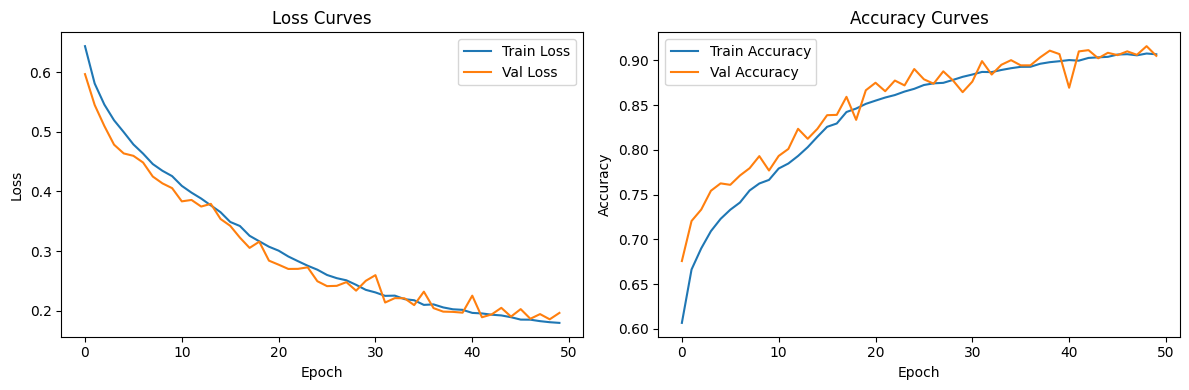

In [12]:
# --- Step 10: Plot Training Metrics (Optional) ---

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [ ]:
# Input → CNN → Patch Embedding → Positional Embedding → Transformer Encoder (repeated) → Classifier (LayerNorm + Linear).